In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline


import re
import string
from wordcloud import WordCloud

from textblob import TextBlob

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

import joblib

In [2]:
train = pd.read_csv("../Dataset/twitter_parsed_dataset.csv")

In [3]:
train.head()

,index,id,Text,Annotation,oh_label
0,5.75E+17,5.75E+17,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.72E+17,5.72E+17,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90E+17,3.90E+17,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68E+17,5.68E+17,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.76E+17,5.76E+17,#mkr No No No No No No,none,0.0


In [4]:
data = train.drop(columns=['index','id'])

In [5]:
data

,Text,Annotation,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,#mkr No No No No No No,none,0.0
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",none,0.0
16847,#MKR 'pretty good dishes we're happy with' - O...,none,0.0
16848,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0


D:\Revi\Programs\Conda\TMLC\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='oh_label', ylabel='count'>

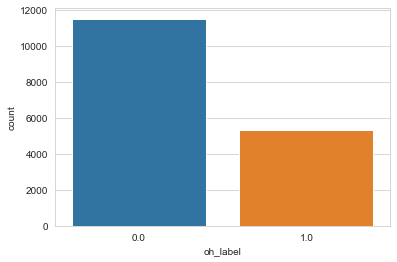

In [24]:
sns.countplot(data.oh_label)

In [6]:
data['Text'].sample(1).values[0]

'@BrentonPoke yes'

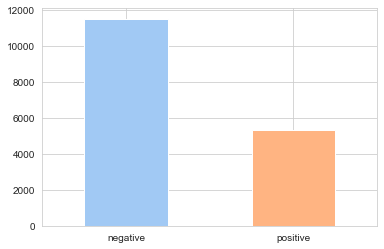

In [31]:
data['oh_label'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))
plt.xticks([0,1],['negative', 'positive'], rotation=0);

# Data EDA & Preprocessing (Cleaning and Inspecting)

In [7]:
data.isna().sum()

Text          1
Annotation    3
oh_label      3
dtype: int64

In [8]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Revi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [9]:
def change_case_lower(text):
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    
    return sample

def remove_url(text):
    sample = text
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    
    return sample

def remove_html(text):
    sample = text
    comp = re.compile(r'<.*?>')
    sample = re.sub(comp, '', sample)
    
    return sample

def remove_punctuations(text):
    sample = text
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    
    return sample

only_english = set(nltk.corpus.words.words())
def remove_special_characters(text):
    sample = text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

def remove_hashtags_total(text):
    sample = text
    sample = re.sub('#', ' ', sample)
    
    return sample

def remove_hashtags_only(text):
    sample = text
    sample = ' '.join([x for x in s.split() if not x.startswith('#')])
    
    return sample

def remove_emojis(text):
    sample = text
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    return sample

In [10]:
## A. TOTAL NUMBER OF WORDS USED 
data['nb_words'] = data.Text.apply(lambda x: len(x.split()))

## B. TOTAL NUMBER OF UNIQUE WORDS USED
data['nb_unique_words'] = data.Text.apply(lambda x: len(set(x.split())))

## C. TOTAL NUMBER OF CHARACTERS USED
data['nb_char'] = data.Text.apply(lambda x: len(x))

AttributeError: 'float' object has no attribute 'split'

In [11]:
text_sample = data['Text'].sample(1).values[0]
text_sample

'@Vonta624 Look dude black women are beneath you on the shitty world white supremacist hierarchy maybe try solidarity'

In [12]:
change_case_lower(text_sample)

'@vonta624 look dude black women are beneath you on the shitty world white supremacist hierarchy maybe try solidarity'

In [13]:
remove_url(text_sample)

'@Vonta624 Look dude black women are beneath you on the shitty world white supremacist hierarchy maybe try solidarity'

In [14]:
remove_html(text_sample)

'@Vonta624 Look dude black women are beneath you on the shitty world white supremacist hierarchy maybe try solidarity'

In [15]:
remove_punctuations(text_sample)

'Vonta624 Look dude black women are beneath you on the shitty world white supremacist hierarchy maybe try solidarity'

In [16]:
remove_special_characters(text_sample)

'Vonta624 Look dude black are beneath you on the world white hierarchy maybe try solidarity'

In [17]:
remove_hashtags_total(text_sample)

'@Vonta624 Look dude black women are beneath you on the shitty world white supremacist hierarchy maybe try solidarity'

In [18]:
remove_emojis(text_sample)

'@Vonta624 Look dude black women are beneath you on the shitty world white supremacist hierarchy maybe try solidarity'

In [19]:
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

In [20]:
data['Text'] = data['Text'].fillna("")

In [21]:
data['cleaned_text'] = data['Text'].apply(lambda x: clean_text(x))
data

,Text,Annotation,oh_label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,shreyabafna3 now you claim that people who tri...
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,call me but when i go to an auto place id rath...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,wrong the example of and the exactly
4,#mkr No No No No No No,none,0.0,no no no no no no
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",none,0.0,feeling so sorry for the they should be safe a...
16847,#MKR 'pretty good dishes we're happy with' - O...,none,0.0,pretty good were happy with well never eating ...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0,lemon we please go just one season of without ...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0,you are too stupid to talk to blocked


In [53]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Revi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [22]:
# Caching stopwords outside for better speed
stops = set(stopwords.words('english'))
def remove_stop_words(text, cores = 2):
    
    sample = text
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    return sample


# get POS Tag for word
def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Lemmatizing the data
# Steps to convert : Document -> Sentences -> Tokens -> POS -> Lemmas
lemmatizer = WordNetLemmatizer()
def lemma_clean_text(text, cores = 1):
 
    sample = text
    sample = sample.split()
    sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
    sample = ' '.join(sample)
    
    return sample


# Stemming the data
ps = PorterStemmer()
def stem_clean_text(text):
 
    sample = text
    sample = sample.split()
    sample = [ps.stem(word) for word in sample]
    sample = ' '.join(sample)
    
    return sample

def correct_spelling(text):
    
    sample = text
    sample = str(TextBlob(text).correct())
    
    return sample

In [23]:
remove_stop_words(text_sample)

'@vonta624 look dude black women beneath shitty world white supremacist hierarchy maybe try solidarity'

In [24]:
stem_clean_text(text_sample)

'@vonta624 look dude black women are beneath you on the shitti world white supremacist hierarchi mayb tri solidar'

In [25]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Revi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Revi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Revi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [27]:
text_sample

'@Vonta624 Look dude black women are beneath you on the shitty world white supremacist hierarchy maybe try solidarity'

In [28]:
lemma_clean_text(text_sample)

KeyError: None

In [29]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

In [30]:
data['correct_text'] = data['cleaned_text'].apply(lambda x: correct_text(x))
data

,Text,Annotation,oh_label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,i read them in change in meaning the history o...,read change meaning history slavery
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,shreyabafna3 now you claim that people who tri...,shreyabafna3 claim people tried stop becoming ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,call me but when i go to an auto place id rath...,call go auto place id rather talk guy
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,wrong the example of and the exactly,wrong example exactly
4,#mkr No No No No No No,none,0.0,no no no no no no,
...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",none,0.0,feeling so sorry for the they should be safe a...,feeling sorry safe kat going home
16847,#MKR 'pretty good dishes we're happy with' - O...,none,0.0,pretty good were happy with well never eating ...,pretty good happy well never eating place
16848,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0,lemon we please go just one season of without ...,lemon please go one season without someone cal...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0,you are too stupid to talk to blocked,stupid talk blocked


In [31]:
data['word_count'] = data['correct_text'].apply(lambda x: len(str(x).split(" ")))
data[['correct_text','word_count']]

,correct_text,word_count
0,read change meaning history slavery,5
1,shreyabafna3 claim people tried stop becoming ...,11
2,call go auto place id rather talk guy,8
3,wrong example exactly,3
4,,1
...,...,...
16846,feeling sorry safe kat going home,6
16847,pretty good happy well never eating place,7
16848,lemon please go one season without someone cal...,9
16849,stupid talk blocked,3


<AxesSubplot:>

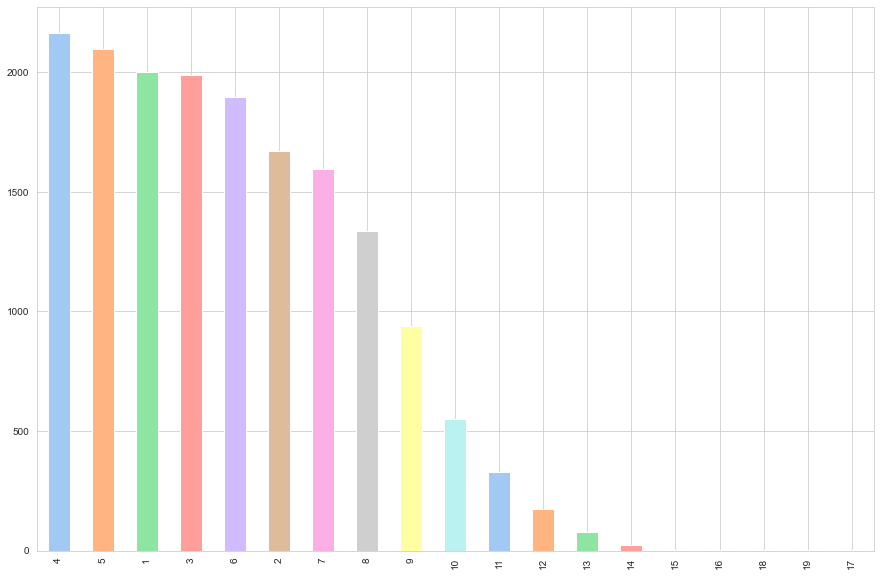

In [73]:
plt.figure(figsize=(15,10))
data['word_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [32]:
data['char_count'] = data['correct_text'].str.len() ## this also includes spaces
data[['correct_text','char_count']]

,correct_text,char_count
0,read change meaning history slavery,35
1,shreyabafna3 claim people tried stop becoming ...,81
2,call go auto place id rather talk guy,37
3,wrong example exactly,21
4,,0
...,...,...
16846,feeling sorry safe kat going home,33
16847,pretty good happy well never eating place,41
16848,lemon please go one season without someone cal...,60
16849,stupid talk blocked,19


<AxesSubplot:>

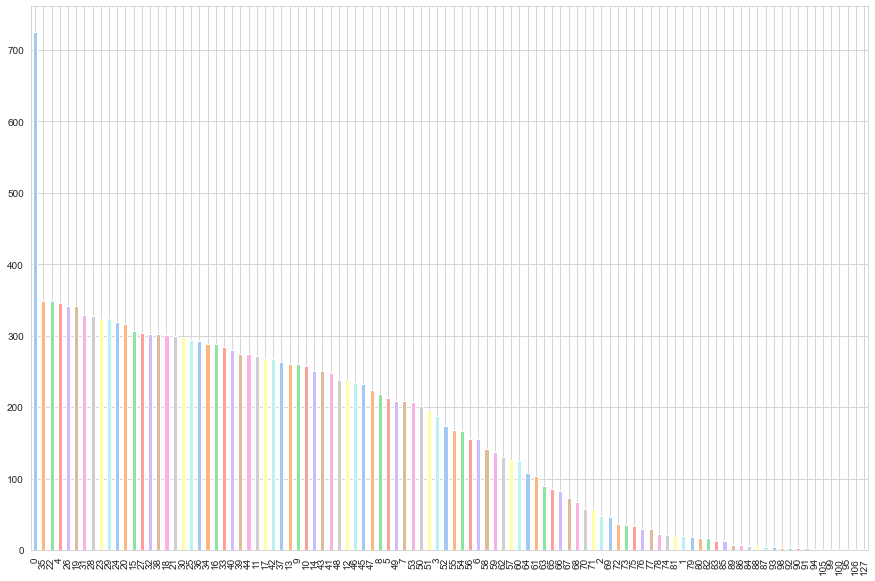

In [33]:
plt.figure(figsize=(15,10))
data['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [34]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/(len(words)+0.000001))

data['avg_word'] = data['correct_text'].apply(lambda x: avg_word(x)).round(1)
data[['correct_text','avg_word']].head()

,correct_text,avg_word
0,read change meaning history slavery,6.2
1,shreyabafna3 claim people tried stop becoming ...,6.5
2,call go auto place id rather talk guy,3.7
3,wrong example exactly,6.3
4,,0.0


<AxesSubplot:>

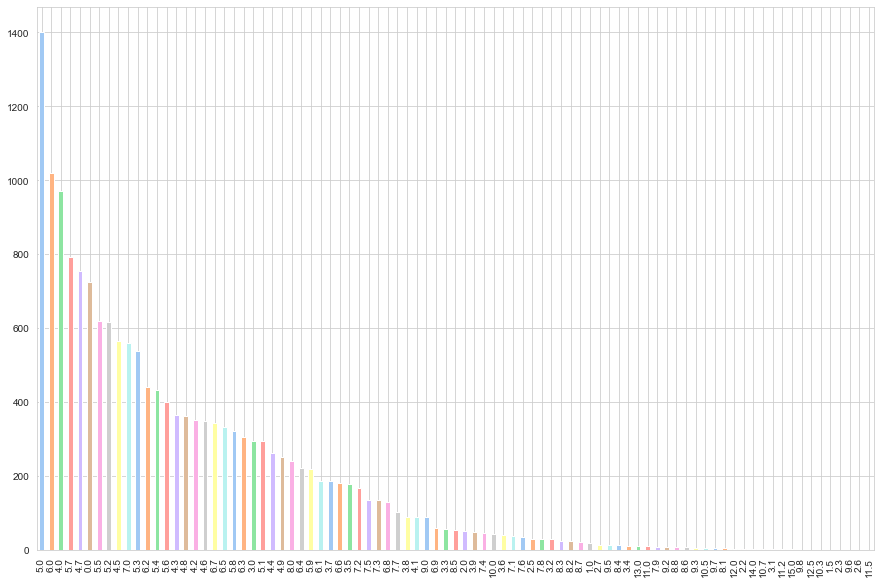

In [35]:
plt.figure(figsize=(15,10))
data['avg_word'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [36]:
final_data = data[['correct_text', 'word_count', 'char_count', 'avg_word', 'oh_label']]
final_data

,correct_text,word_count,char_count,avg_word,oh_label
0,read change meaning history slavery,5,35,6.2,0.0
1,shreyabafna3 claim people tried stop becoming ...,11,81,6.5,0.0
2,call go auto place id rather talk guy,8,37,3.7,1.0
3,wrong example exactly,3,21,6.3,1.0
4,,1,0,0.0,0.0
...,...,...,...,...,...
16846,feeling sorry safe kat going home,6,33,4.7,0.0
16847,pretty good happy well never eating place,7,41,5.0,0.0
16848,lemon please go one season without someone cal...,9,60,5.8,0.0
16849,stupid talk blocked,3,19,5.7,0.0


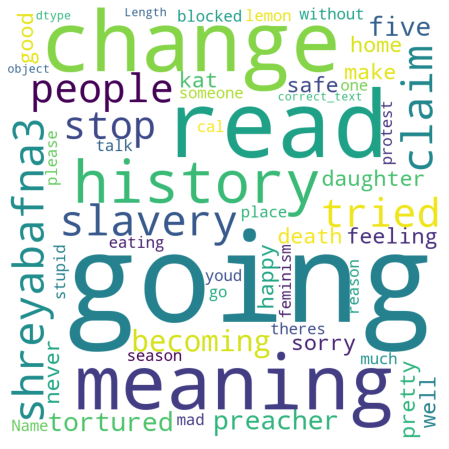

In [37]:
g = str(data[data['oh_label']==0]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

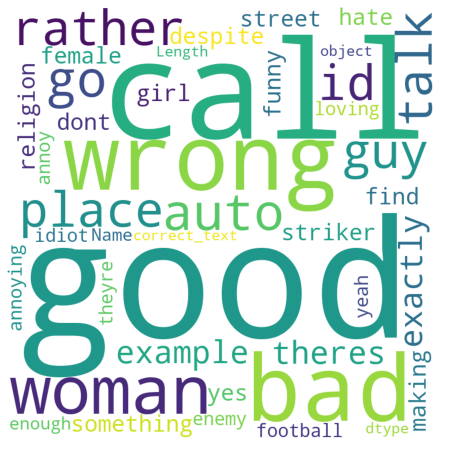

In [38]:
g = str(data[data['oh_label']==1]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [39]:
X = final_data.drop(columns=['oh_label'])
y = final_data['oh_label']
# z = final.drop(columns=['correct_text', 'sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [40]:
z_train = X_train.drop(columns=['correct_text'])
z_test = X_test.drop(columns=['correct_text'])

X_train = X_train['correct_text']
X_test = X_test['correct_text']

In [86]:
X_train

5157         able afford another monitor sadly tech budget
16382                    safe strategically marking id put
362                                   end last nights show
9322                                      think dont human
15520                               know plenty people bye
                               ...                        
2623              like torture defend doesnt seem convince
12363    turned woman normal human function like eating...
5695                                                      
8006      might get shut legal name name known anyone know
13151                           course slavery rape female
Name: correct_text, Length: 11290, dtype: object

In [41]:
z_test

,word_count,char_count,avg_word
3234,1,7,7.0
16252,6,37,5.3
5145,7,33,3.9
4627,6,39,5.7
11057,4,22,4.7
...,...,...,...
5413,1,0,0.0
5229,4,21,4.5
1707,3,14,4.0
7423,6,29,4.0


**BagOfWords (CBOW)**


The idea is to analyze the documents. The document here refers to a unit. In case we want to find all the negative tweets during the pandemic, each tweet here is a document. To obtain the bag of words we always perform all those pre-requisite steps like cleaning, stemming, lemmatization, etc… Then we generate a set of all the words that are available before sending it for modeling. We can get repeated words within our document. A better representation is a vector form, that can tell us how many times each word can occur in a document. The following is called a document term matrix and is shown below:

<img src="https://qph.fs.quoracdn.net/main-qimg-27639a9e2f88baab88a2c575a1de2005">

row1: "Today is independence day" {"Today":0, "is": 1, "independence": 2, "day": 3}
row2: "independence day is celebrated"  {"independence":0, "day": 1, "is": 2, "celebrated": 3}
       independece
1    (value=freq=1)

In [42]:
bow = CountVectorizer(max_features=500)

In [43]:
X_train_vect = bow.fit_transform(X_train)
X_test_vect = bow.transform(X_test)

In [44]:
x_t1 = pd.DataFrame(X_train_vect.toarray(),columns=bow.get_feature_names())
x_t2 = pd.DataFrame(X_test_vect.toarray(),columns=bow.get_feature_names())

D:\Revi\Programs\Conda\TMLC\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
x_t1

,able,absolutely,abuse,account,actually,ago,agree,air,alima,almost,...,would,wouldnt,wow,wrong,yeah,year,yes,yet,youve,zero
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
x_train = pd.concat([x_t1, z_train.reset_index(drop=True)], axis=1)
x_test = pd.concat([x_t2, z_test.reset_index(drop=True)], axis=1)

In [47]:
x_train

,able,absolutely,abuse,account,actually,ago,agree,air,alima,almost,...,wrong,yeah,year,yes,yet,youve,zero,word_count,char_count,avg_word
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,45,5.6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,33,5.8
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,20,4.2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,16,4.7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,22,4.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,40,5.8
11286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,13,87,5.8
11287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
11288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,48,4.4


In [48]:
y_train.isna().sum()

3

In [49]:
y_train

5157     0.0
16382    0.0
362      0.0
9322     1.0
15520    0.0
        ... 
2623     0.0
12363    0.0
5695     0.0
8006     0.0
13151    1.0
Name: oh_label, Length: 11290, dtype: float64

In [50]:
y_train = y_train.fillna(0)

In [51]:
clf = MultinomialNB()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

In [52]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
#     if len(actual.shape) == 1:
#         actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
#         for i, val in enumerate(actual):
#             actual2[i, val] = 1
#         actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [53]:
print("logloss: %0.3f " % multiclass_logloss(y_test.values, pred))

logloss: 6.410 


**Tf-Idf**

One problem that we encounter in the bag-of-words approach is that it treats every word equally, but in a document, there is a high chance of particular words being repeated more often than others. if we take each sentence as a document, we can count the number of documents each time any word occurs. This method is called document-frequency. We then divide the term frequency by the document frequency of that word. This helps us with the frequency of occurrence of terms in that document and inverse to the number of documents it appears in. Thus we have the TF-IDF. The idea is to assign particular weights to words that tell us about how important they are in the document.

<img src="https://editor.analyticsvidhya.com/uploads/88298tfidf_ex3.png">

In [106]:
tfidf = TfidfVectorizer(stop_words='english')

In [107]:
X_train_vect = tfidf.fit_transform(X_train)
X_test_vect = tfidf.transform(X_test)

In [108]:
x_t1 = pd.DataFrame(X_train_vect.toarray(),columns=tfidf.get_feature_names())
x_t2 = pd.DataFrame(X_test_vect.toarray(),columns=tfidf.get_feature_names())

D:\Revi\Programs\Conda\TMLC\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [109]:
x_t1

,aaronstein1,abandon,abandonment,abbas,abbot,aberration,abhorrent,abiding,ability,able,...,youve,yr,yuck,yummy,zebra,zero,zip,zone,zoo,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.335584,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
x_train = pd.concat([x_t1, z_train.reset_index(drop=True)], axis=1)
x_test = pd.concat([x_t2, z_test.reset_index(drop=True)], axis=1)

In [111]:
clf = MultinomialNB()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

In [112]:
print("logloss: %0.3f " % multiclass_logloss(y_test.values, pred))

logloss: 8.726 


**Word2Vec (Skip-Gram)**

Word2Vec is widely used in most of the NLP models. It transforms the word into vectors. Word2vec is a two-layer net that processes text with words. The input is in the text corpus and the output is a set of vectors: feature vectors represent the words on that corpus.


Given enough data, usage, and conditions, Word2vec can make the most accurate predictions about the meaning of a word based on previous appearances. That guess can be used to form word-and-word combinations (eg “big” i.e. “large” to say “small” is “tiny”), or group texts and separate them by topic.

**GloVe**

GloVe – global vector for word representation. An unsupervised learning algorithm by Stanford is used to generate embedding words by combining a word matrix for the word co-occurrence of matrix from the corpus. Emerging embedded text shows an attractive line format for a word in a vector space. The GloVe model is trained in the zero-level global co-occurrence matrix, which shows how often words meet in a particular corpus.

<img src="https://editor.analyticsvidhya.com/uploads/619221_gcC7b_v7OKWutYN1NAHyMQ.png">

In [131]:
class Word_to_Vect():
    '''Function that returns word embedding, if passed list of sentences and size of vector'''
    
    def __init__(self):
        pass

        
    def w2v(self, corpus, size):
        
        #tokenization and model preparation
        tokenize_sent = [sent.split() for sent in corpus]
        #creating vord2vec for every word in every sentence in corpus
        self.w2v = word2vec.Word2Vec(tokenize_sent, vector_size=size, min_count=1)
        
        return self.w2v
    
    def transform(self, X_corpus, size):
        
        array_wordEmbed = []
        for sent in X_corpus:
            vec = np.zeros(size).reshape((1, size))
            count = 0.
            if sent == '':
                a = vec
            else:
                sent = sent.split(' ')
                for word in sent:
                    vec += w2v[word].reshape((1,size))
                    count +=1
            if count !=0:
                vec /= count
            a = vec
            array_wordEmbed.append(a)
        return np.concatenate(tuple(array_wordEmbed))

In [123]:
X['correct_text']

0                      read change meaning history slavery
1        shreyabafna3 claim people tried stop becoming ...
2                    call go auto place id rather talk guy
3                                    wrong example exactly
4                                                         
                               ...                        
16846                    feeling sorry safe kat going home
16847            pretty good happy well never eating place
16848    lemon please go one season without someone cal...
16849                                  stupid talk blocked
16850         protest mad theres much reason youd feminism
Name: correct_text, Length: 16851, dtype: object

In [133]:
w2v = Word_to_Vect().w2v(corpus = [sent for sent in X['correct_text']], size = len(X['correct_text']))

model's vocab gives the dictionary of words along with their vector values,  
and the values of the dictionary will give you the value of that word  

**Example**

In [134]:
w2v.wv.similar_by_vector('bad')

[('much', 0.9999982118606567),
 ('still', 0.9999982118606567),
 ('people', 0.9999982118606567),
 ('woman', 0.9999980926513672),
 ('one', 0.9999980926513672),
 ('trying', 0.9999980926513672),
 ('men', 0.9999980330467224),
 ('want', 0.9999980330467224),
 ('two', 0.9999980330467224),
 ('even', 0.9999980330467224)]

In [136]:
w2v.wv['bad']

array([ 0.02040852,  0.06601698, -0.04447178, ...,  0.00324473,
       -0.03745423,  0.03064254], dtype=float32)

In [139]:
words = list(w2v.wv.index_to_key)
#w2v.wv.vocab
words

['kat',
 'like',
 'dont',
 'people',
 'get',
 'one',
 'think',
 'would',
 'know',
 'cant',
 'go',
 'want',
 'time',
 'good',
 'really',
 'going',
 'see',
 'men',
 'make',
 'even',
 'oh',
 'thats',
 'never',
 'need',
 'call',
 'way',
 'still',
 'right',
 'well',
 'say',
 'hate',
 'woman',
 'much',
 'back',
 'got',
 'female',
 'doesnt',
 'us',
 'ever',
 'love',
 'didnt',
 'stop',
 'every',
 'many',
 'look',
 'someone',
 'thing',
 'twitter',
 'another',
 'show',
 'better',
 'pretty',
 'man',
 'cook',
 'yes',
 'religion',
 'bad',
 'take',
 'read',
 'sure',
 'world',
 'nothing',
 'could',
 'actually',
 'hope',
 'cooking',
 'colin',
 'tell',
 'yeah',
 'p',
 'give',
 'day',
 'prophet',
 'talk',
 'food',
 'two',
 'work',
 'stupid',
 'face',
 'anyone',
 'anything',
 'use',
 'sorry',
 'round',
 'please',
 'made',
 'theyre',
 'believe',
 'real',
 'last',
 'something',
 'wrong',
 'death',
 'god',
 'war',
 'idea',
 'also',
 'find',
 'must',
 'next',
 'said',
 'try',
 'new',
 'always',
 'first',
 'w

***We can create the document-term matrix by creating a dictionary with `"word": "value"`, using the below function***

In [140]:
X_w2v = pd.DataFrame({word:w2v.wv[word] for sent in X['correct_text'] for word in sent.split()})
X_w2v

,read,change,meaning,history,slavery,shreyabafna3,claim,people,tried,stop,...,prosecutor,delaying,reb,lorry,accomplishment,overdramatic,feat,apocalypse,rossbarnes9,pacify
0,0.020121,0.008505,0.004426,0.010714,0.012081,0.000395,0.009934,0.027948,0.004760,0.020856,...,0.000329,0.000331,0.000199,0.000363,0.000307,0.000188,0.000458,0.000343,0.000061,0.000325
1,0.064917,0.027632,0.014211,0.034473,0.039182,0.001266,0.032292,0.090358,0.015394,0.067149,...,0.001127,0.001168,0.000774,0.001015,0.000814,0.000429,0.001639,0.000994,0.000246,0.001196
2,-0.043667,-0.018578,-0.009603,-0.023228,-0.026404,-0.000888,-0.021684,-0.060737,-0.010344,-0.045163,...,-0.000785,-0.000831,-0.000491,-0.000635,-0.000529,-0.000298,-0.001083,-0.000729,-0.000171,-0.000847
3,-0.012459,-0.005275,-0.002675,-0.006586,-0.007489,-0.000195,-0.006126,-0.017197,-0.002963,-0.012821,...,-0.000277,-0.000207,-0.000167,-0.000163,-0.000183,-0.000073,-0.000316,-0.000171,-0.000035,-0.000250
4,-0.026425,-0.011241,-0.005842,-0.014030,-0.015919,-0.000559,-0.013094,-0.036776,-0.006282,-0.027473,...,-0.000445,-0.000517,-0.000291,-0.000428,-0.000309,-0.000222,-0.000714,-0.000443,-0.000078,-0.000477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16846,0.012913,0.005512,0.002850,0.006840,0.007745,0.000242,0.006476,0.018002,0.003015,0.013364,...,0.000221,0.000264,0.000104,0.000225,0.000162,0.000089,0.000292,0.000194,0.000114,0.000214
16847,-0.001465,-0.000663,-0.000275,-0.000775,-0.000911,-0.000068,-0.000745,-0.002020,-0.000351,-0.001490,...,-0.000057,-0.000086,0.000037,-0.000030,-0.000027,0.000011,-0.000031,-0.000021,-0.000007,0.000009
16848,0.003234,0.001412,0.000665,0.001761,0.001931,0.000023,0.001601,0.004533,0.000823,0.003321,...,0.000082,0.000005,0.000072,-0.000007,0.000088,0.000071,0.000070,0.000051,0.000047,0.000057
16849,-0.036827,-0.015698,-0.008115,-0.019536,-0.022268,-0.000715,-0.018250,-0.051274,-0.008778,-0.038081,...,-0.000616,-0.000628,-0.000464,-0.000574,-0.000503,-0.000282,-0.000969,-0.000570,-0.000186,-0.000619


In [141]:
x_t1, x_t2, _, _ = train_test_split(X_w2v, y, test_size=0.33, random_state=101)

In [142]:
x_t2

,read,change,meaning,history,slavery,shreyabafna3,claim,people,tried,stop,...,prosecutor,delaying,reb,lorry,accomplishment,overdramatic,feat,apocalypse,rossbarnes9,pacify
3234,-0.043790,-0.018574,-0.009609,-0.023196,-0.026406,-0.000885,-0.021779,-0.060927,-0.010461,-0.045307,...,-0.000742,-0.000758,-0.000561,-0.000642,-0.000511,-0.000304,-0.001095,-0.000715,-0.000162,-0.000825
16252,-0.003761,-0.001645,-0.000788,-0.001946,-0.002234,-0.000031,-0.001898,-0.005224,-0.000926,-0.003962,...,-0.000094,-0.000021,0.000009,-0.000072,-0.000060,-0.000068,-0.000056,-0.000008,-0.000046,-0.000081
5145,-0.028628,-0.012208,-0.006348,-0.015281,-0.017329,-0.000549,-0.014272,-0.039911,-0.006797,-0.029658,...,-0.000542,-0.000488,-0.000304,-0.000477,-0.000406,-0.000173,-0.000737,-0.000453,-0.000137,-0.000540
4627,0.023226,0.009856,0.005054,0.012348,0.013970,0.000510,0.011497,0.032295,0.005496,0.024004,...,0.000404,0.000400,0.000307,0.000327,0.000273,0.000123,0.000625,0.000398,0.000095,0.000390
11057,0.060888,0.025853,0.013377,0.032406,0.036728,0.001259,0.030343,0.084799,0.014537,0.063165,...,0.001084,0.001114,0.000690,0.000942,0.000777,0.000394,0.001596,0.001031,0.000255,0.001064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5413,-0.000620,-0.000258,-0.000183,-0.000333,-0.000458,-0.000070,-0.000310,-0.000880,-0.000113,-0.000743,...,0.000007,0.000014,-0.000020,-0.000026,0.000013,0.000040,0.000037,-0.000070,-0.000017,-0.000014
5229,-0.010306,-0.004345,-0.002282,-0.005414,-0.006122,-0.000162,-0.005048,-0.014335,-0.002478,-0.010659,...,-0.000209,-0.000152,-0.000091,-0.000208,-0.000139,-0.000107,-0.000272,-0.000183,-0.000055,-0.000139
1707,0.011260,0.004765,0.002517,0.005996,0.006861,0.000268,0.005649,0.015782,0.002735,0.011733,...,0.000174,0.000187,0.000148,0.000189,0.000198,0.000098,0.000241,0.000197,0.000091,0.000193
7423,0.013134,0.005607,0.002829,0.006930,0.007875,0.000220,0.006518,0.018233,0.003118,0.013614,...,0.000268,0.000302,0.000158,0.000240,0.000139,0.000086,0.000310,0.000244,0.000034,0.000251


In [54]:
x_train = pd.concat([x_t1.reset_index(drop=True), z_train.reset_index(drop=True)], axis=1)
x_test = pd.concat([x_t2.reset_index(drop=True), z_test.reset_index(drop=True)], axis=1)

In [57]:
clf = XGBClassifier()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

[13:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [58]:
print("logloss: %0.3f " % multiclass_logloss(y_test.values, pred))

logloss: 7.136 


# Save the model


In [147]:
#saving the model
clf.save_model('../Model/CyberBully_ML_Model.h5')